In [1]:
import pandas as pd

In [2]:
weather_data = pd.read_csv('Data/auxiliarydata/forecast/forecast.csv.gz', compression='gzip', delimiter='\t', parse_dates=['dateforecastfor', 'dateforecastmade'], index_col='dateforecastfor')

In [3]:
weather_data = weather_data.sort_index()

In [4]:
weather_data

,locationid,dateforecastmade,maxtemp,mintemp,tempunit,conditions,conditionsicon
dateforecastfor,,,,,,,
2016-08-10,Edinburgh,2016-08-10,13,12,C,Rain,http://icons.wxug.com/i/c/k/rain.gif
2016-08-11,Edinburgh,2016-08-11,17,14,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif
2016-08-12,Edinburgh,2016-08-12,17,12,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif
2016-08-13,Edinburgh,2016-08-13,16,11,C,Mostly Cloudy,http://icons.wxug.com/i/c/k/mostlycloudy.gif
2016-08-14,Edinburgh,2016-08-14,17,9,C,Partly Cloudy,http://icons.wxug.com/i/c/k/partlycloudy.gif
...,...,...,...,...,...,...,...
2018-12-30,EastLothian,2018-12-27,11,7,C,Partly Cloudy,http://icons.wxug.com/i/c/k/partlycloudy.gif
2018-12-30,Edinburgh,2018-12-30,11,7,C,Partly Cloudy,http://icons.wxug.com/i/c/k/partlycloudy.gif
2018-12-30,WestLothian,2018-12-27,9,6,C,Overcast,http://icons.wxug.com/i/c/k/cloudy.gif


In [5]:
min_max_temp = weather_data[['locationid', 'maxtemp', 'mintemp']]

In [6]:
min_max_temp_edin = min_max_temp[min_max_temp['locationid'] == 'Edinburgh'].drop(columns='locationid')

In [7]:
min_max_temp_edin

,maxtemp,mintemp
dateforecastfor,,
2016-08-10,13,12
2016-08-11,17,14
2016-08-12,17,12
2016-08-13,16,11
2016-08-14,17,9
...,...,...
2018-12-26,10,7
2018-12-27,10,6
2018-12-28,10,5


In [8]:
hourly_timestamps = pd.date_range(start="2016-08-10", end="2018-12-30", freq="H")

In [9]:
hourly_timestamps = pd.to_datetime(hourly_timestamps)

In [10]:
hourly_timestamps = pd.DataFrame(hourly_timestamps, columns=['hourly_timestamp'])

In [11]:
hourly_timestamps

,hourly_timestamp
0,2016-08-10 00:00:00
1,2016-08-10 01:00:00
2,2016-08-10 02:00:00
3,2016-08-10 03:00:00
4,2016-08-10 04:00:00
...,...
20924,2018-12-29 20:00:00
20925,2018-12-29 21:00:00
20926,2018-12-29 22:00:00
20927,2018-12-29 23:00:00


In [12]:
import numpy as np

In [13]:
def hourly_temps_estimation(mintemp, maxtemp):
    avg_temp = np.mean([mintemp, maxtemp])
    amplitude = (np.ptp([mintemp, maxtemp]))/2
    
    t_min = 5
    hourly_temps = []
    
    for hour in range(24):
        temp = avg_temp + amplitude * (np.sin((2 * np.pi * (hour-t_min))/24 - (5 * np.pi / 12)))
        
        hourly_temps.append(temp)
    
    return hourly_temps

In [14]:
hourly_temps_dict = {}

for date, row in min_max_temp_edin.iterrows():
    hourly_temps_dict[date] = hourly_temps_estimation(row['mintemp'], row['maxtemp'])    

In [15]:
# Define function to retrieve temperature based on timestamp
def get_temperature(ts, hourly_temps_dict):
    # converts the timestamps of hourly_timestamp (hours,minutes and seconds) into midnight time to match the key of hourly_temps_dict and stores it to a variable
    date_key = ts.normalize()
    
    # for each normalised date_key, it returns the temperature that corresponds to the 'hour' component of the hourly_timestamps 
    # which means that if the ts.hour is 15 then it will extract the 15th element of the dictionary to match it.
    if date_key in hourly_temps_dict:
        return hourly_temps_dict[date_key][ts.hour]
    else:
        return None  # Return None if date is not found in the dictionary

hourly_timestamps['temperature'] = hourly_timestamps['hourly_timestamp'].apply(get_temperature, args=(hourly_temps_dict,))

In [16]:
print(hourly_timestamps)

         hourly_timestamp  temperature
0     2016-08-10 00:00:00    12.250000
1     2016-08-10 01:00:00    12.146447
2     2016-08-10 02:00:00    12.066987
3     2016-08-10 03:00:00    12.017037
4     2016-08-10 04:00:00    12.000000
...                   ...          ...
20924 2018-12-29 20:00:00     9.500000
20925 2018-12-29 21:00:00     8.776457
20926 2018-12-29 22:00:00     8.000000
20927 2018-12-29 23:00:00     7.223543
20928 2018-12-30 00:00:00     8.000000

[20929 rows x 2 columns]


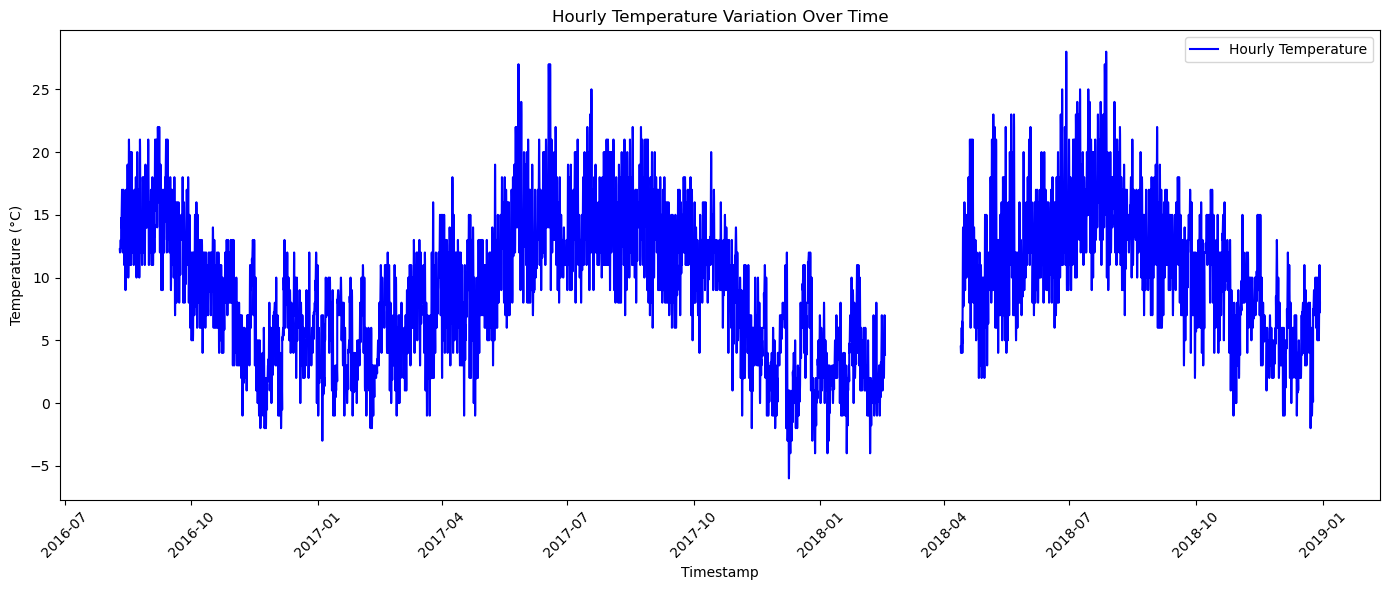

In [17]:
import matplotlib.pyplot as plt

hourly_timestamps['hourly_timestamp'] = pd.to_datetime(hourly_timestamps['hourly_timestamp'])

plt.figure(figsize=(14, 6))
plt.plot(hourly_timestamps['hourly_timestamp'], hourly_timestamps['temperature'], color='blue', label='Hourly Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Hourly Temperature Variation Over Time')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

In [18]:
print(f'{hourly_timestamps[hourly_timestamps.isnull().any(axis=1)].min()}')
print(f'{hourly_timestamps[hourly_timestamps.isnull().any(axis=1)].max()}')

hourly_timestamp    2018-02-17 00:00:00
temperature                         NaN
dtype: object
hourly_timestamp    2018-04-12 23:00:00
temperature                         NaN
dtype: object


In [19]:
hourly_timestamps['temperature_intepolated'] = hourly_timestamps['temperature'].interpolate(method='linear')

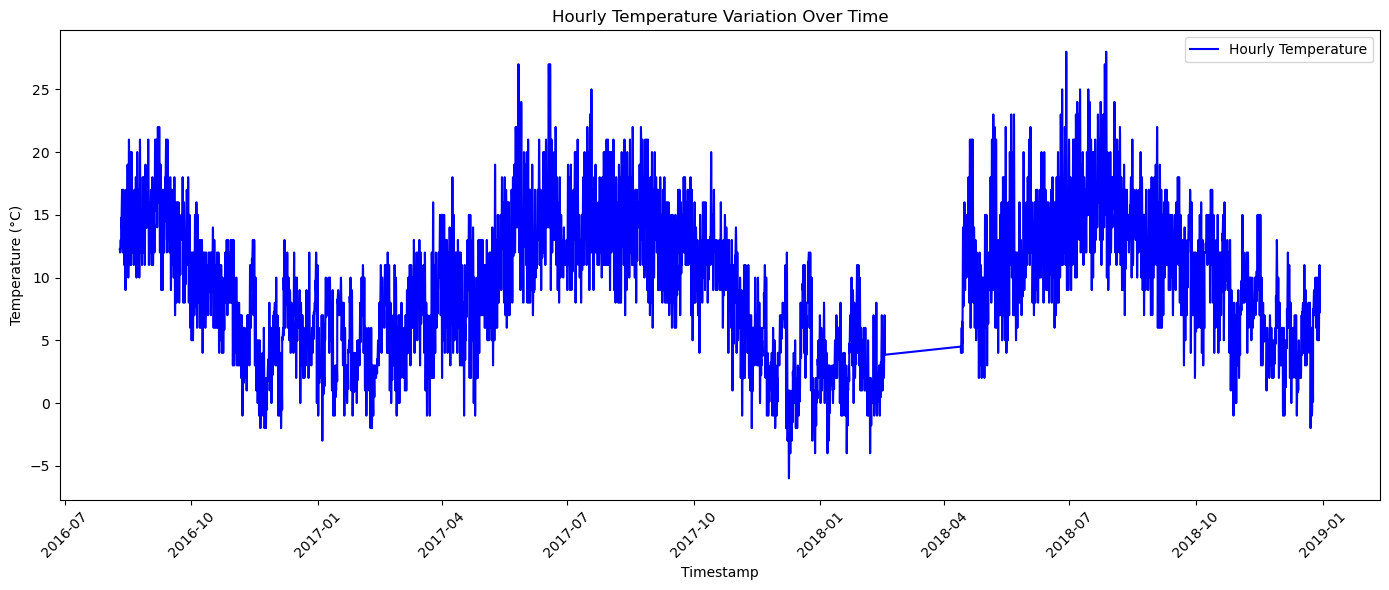

In [20]:
hourly_timestamps['hourly_timestamp'] = pd.to_datetime(hourly_timestamps['hourly_timestamp'])

plt.figure(figsize=(14, 6))
plt.plot(hourly_timestamps['hourly_timestamp'], hourly_timestamps['temperature_intepolated'], color='blue', label='Hourly Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Hourly Temperature Variation Over Time')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

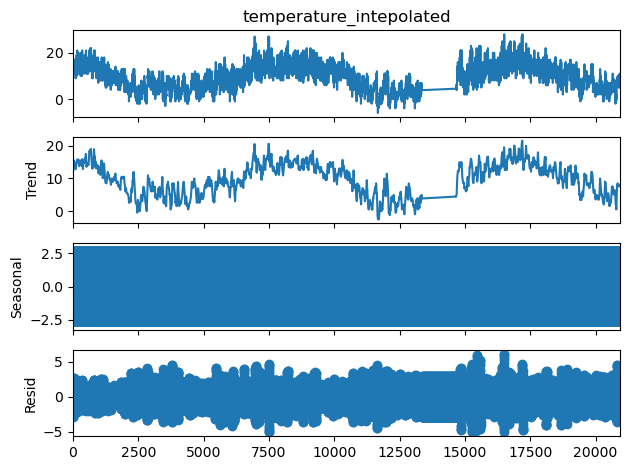

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

temp_seas_decomp = seasonal_decompose(hourly_timestamps['temperature_intepolated'], model='additive', period = 24)

temp_seas_decomp.plot()
plt.show()

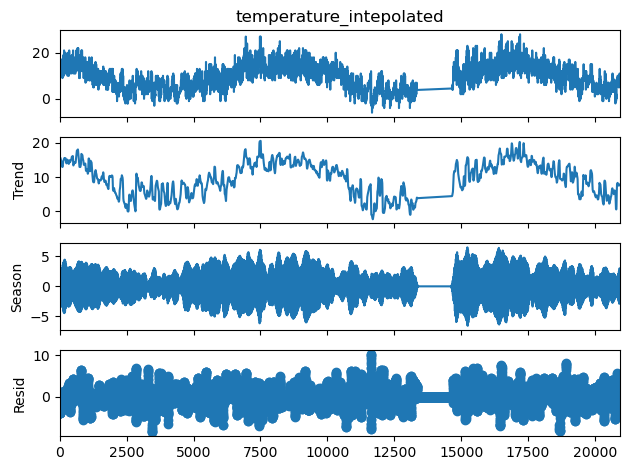

In [22]:
from statsmodels.tsa.seasonal import STL

result = STL(hourly_timestamps['temperature_intepolated'], period = 24, robust = True).fit()

result.plot()
plt.show()

In [23]:
def sine_function(hour, avg_temp, amplitude):

    t_min = 5

    temp = avg_temp + amplitude * np.sin((2 * np.pi * (hour - t_min)) / 24 - (5 * np.pi / 12))
    
    return temp

In [24]:
hourly_timestamps.set_index('hourly_timestamp', inplace=True)

In [25]:
seasonal = result.seasonal
trend = result.trend
residuals = result.resid
residuals_std = residuals.std()

avg_temp = seasonal.mean()
amplitude = (np.ptp([seasonal.min(), seasonal.max()]))/2


In [26]:
residuals_std

1.4339867860124356

In [27]:
trend

0        15.750710
1        15.749191
2        15.747589
3        15.745899
4        15.744113
           ...    
20924     7.870545
20925     7.873790
20926     7.876911
20927     7.879918
20928     7.882816
Name: trend, Length: 20929, dtype: float64

In [28]:
# pass the index of hourly_timestamps to trend 
trend_df = pd.DataFrame(trend.values, index=hourly_timestamps.index, columns=['trend'])


In [29]:
trend_df['hour'] = trend_df.index.hour

hourly_trend_means = trend_df.groupby('hour')['trend'].mean()
print("Hourly trend averages (ignoring NaNs):")
print(hourly_trend_means)

# Map the hourly trend averages back to each row in trend_df, using the hour column
trend_df['hourly_trend_pattern'] = trend_df['hour'].map(hourly_trend_means)

# make it pandas series object
hourly_trend_pattern = trend_df.groupby('hour')['trend'].mean()

Hourly trend averages (ignoring NaNs):
hour
0     9.313338
1     9.315924
2     9.316957
3     9.317982
4     9.318870
5     9.319481
6     9.319695
7     9.319435
8     9.318686
9     9.317507
10    9.316013
11    9.314341
12    9.312609
13    9.310891
14    9.309240
15    9.307709
16    9.306365
17    9.305277
18    9.304495
19    9.304045
20    9.303918
21    9.304087
22    9.304512
23    9.305152
Name: trend, dtype: float64


In [30]:
def monte_carlo_simulation(row,hourly_trend_pattern, amplitude, avg_temp, residual_std, n_simulations=5):
  
    if pd.isnull(row['temperature']):
        
        hour = row.name.hour
        simulated_values = []
        
        for _ in range(n_simulations):
            
            sine_value = sine_function(hour, avg_temp, amplitude*0.3)
            
            trend = hourly_trend_pattern[hour]
            
            random_noise = np.random.normal(0, residual_std* 2.5)
            
            simulated_value = sine_value + trend + random_noise
            simulated_values.append(simulated_value)
           
        return float(np.mean(simulated_values))   
    else:
        return row['temperature']
        

In [31]:
hourly_timestamps['temperature_monte_carlo'] = hourly_timestamps.apply(monte_carlo_simulation, axis=1, hourly_trend_pattern= hourly_trend_pattern, amplitude=amplitude,
    avg_temp=avg_temp, residual_std=residuals_std)

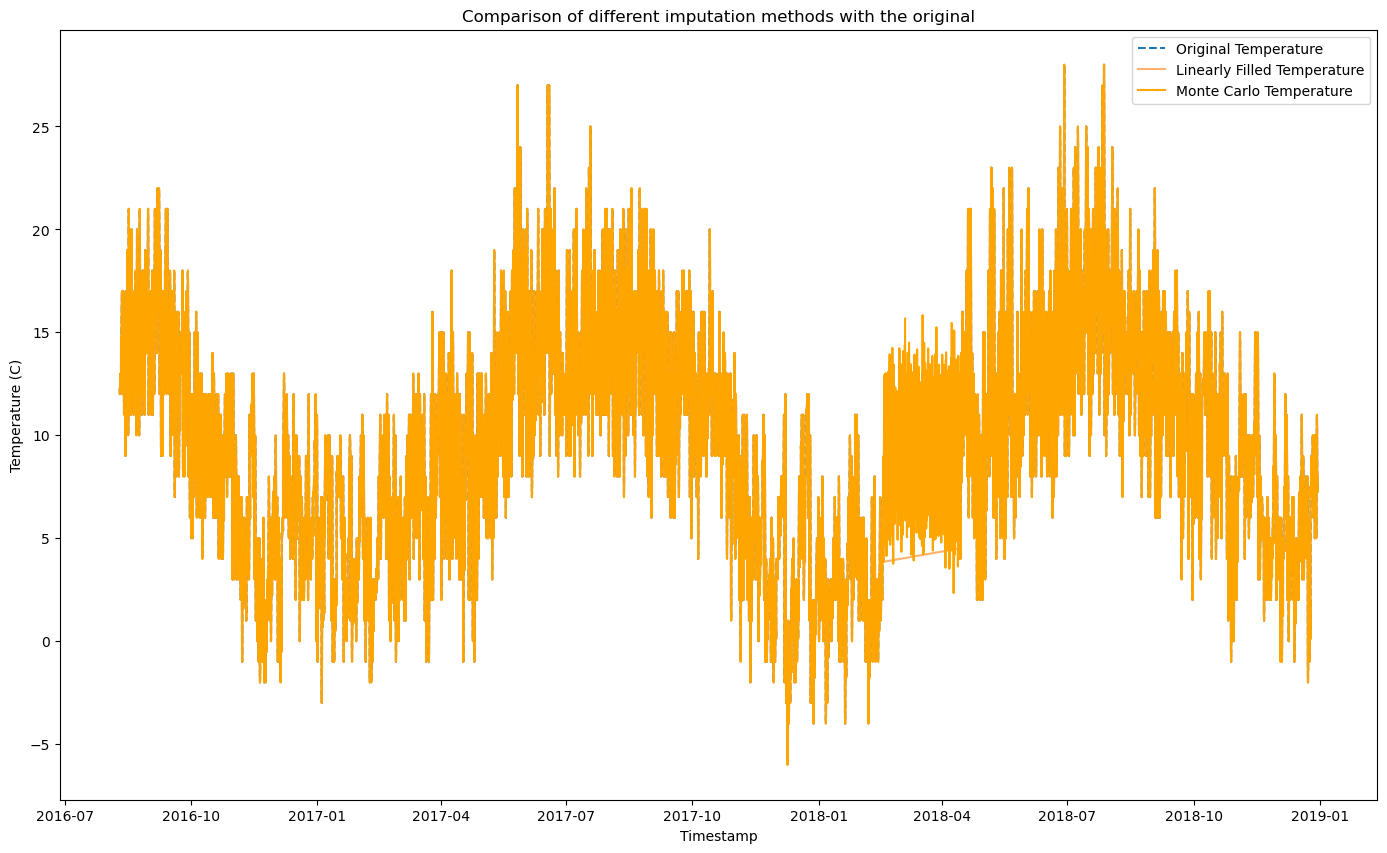

In [32]:
plt.figure(figsize=(17, 10))
plt.plot(hourly_timestamps['temperature'], label = 'Original Temperature', linestyle = '--')
plt.plot(hourly_timestamps['temperature_intepolated'], label = 'Linearly Filled Temperature', alpha = 0.6)
plt.plot(hourly_timestamps['temperature_monte_carlo'], label = 'Monte Carlo Temperature', color = 'orange')
plt.legend()
plt.title('Comparison of different imputation methods with the original')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (C)')
plt.show()

In [33]:
trend_df

,trend,hour,hourly_trend_pattern
hourly_timestamp,,,
2016-08-10 00:00:00,15.750710,0,9.313338
2016-08-10 01:00:00,15.749191,1,9.315924
2016-08-10 02:00:00,15.747589,2,9.316957
2016-08-10 03:00:00,15.745899,3,9.317982
2016-08-10 04:00:00,15.744113,4,9.318870
...,...,...,...
2018-12-29 20:00:00,7.870545,20,9.303918
2018-12-29 21:00:00,7.873790,21,9.304087
2018-12-29 22:00:00,7.876911,22,9.304512


In [34]:
missing_start = "2018-02-17 00:00:00"
missing_end = "2018-04-12 23:00:00"
reference_start = "2017-02-17 00:00:00"
reference_end = "2017-04-12 23:00:00"

In [35]:
reference_trend_2017 = trend_df.loc[reference_start:reference_end, 'trend']

# Step 2: Reindex the reference trend to align with the missing period in 2018
# This will create a trend series for 2018 based on the values from 2017
reference_trend_2018 = reference_trend_2017.copy()
reference_trend_2018.index = pd.date_range(start=missing_start, end=missing_end, freq='H')

# Step 3: Insert the reindexed trend values for 2018 into `trend_df`
# We create a custom trend by using the 2017 values for the missing period in 2018
custom_trend = trend_df['trend'].copy()
custom_trend.loc[missing_start:missing_end] = reference_trend_2018.values

# Verify the custom trend for the missing period in 2018
print("Custom seasonal trend for missing period (Feb-April 2018):")
print(custom_trend.loc[missing_start:missing_end])

Custom seasonal trend for missing period (Feb-April 2018):
hourly_timestamp
2018-02-17 00:00:00    8.029269
2018-02-17 01:00:00    8.035967
2018-02-17 02:00:00    8.042998
2018-02-17 03:00:00    8.050757
2018-02-17 04:00:00    8.059574
                         ...   
2018-04-12 19:00:00    8.501584
2018-04-12 20:00:00    8.496447
2018-04-12 21:00:00    8.487688
2018-04-12 22:00:00    8.474567
2018-04-12 23:00:00    8.456882
Name: trend, Length: 1320, dtype: float64


In [36]:
hourly_timestamps['temperature_custom_trend'] = hourly_timestamps.apply(monte_carlo_simulation, axis=1, hourly_trend_pattern= custom_trend, amplitude=amplitude,
    avg_temp=avg_temp, residual_std=residuals_std)

C:\Users\ggeor\AppData\Local\Temp\ipykernel_48760\648278713.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend = hourly_trend_pattern[hour]


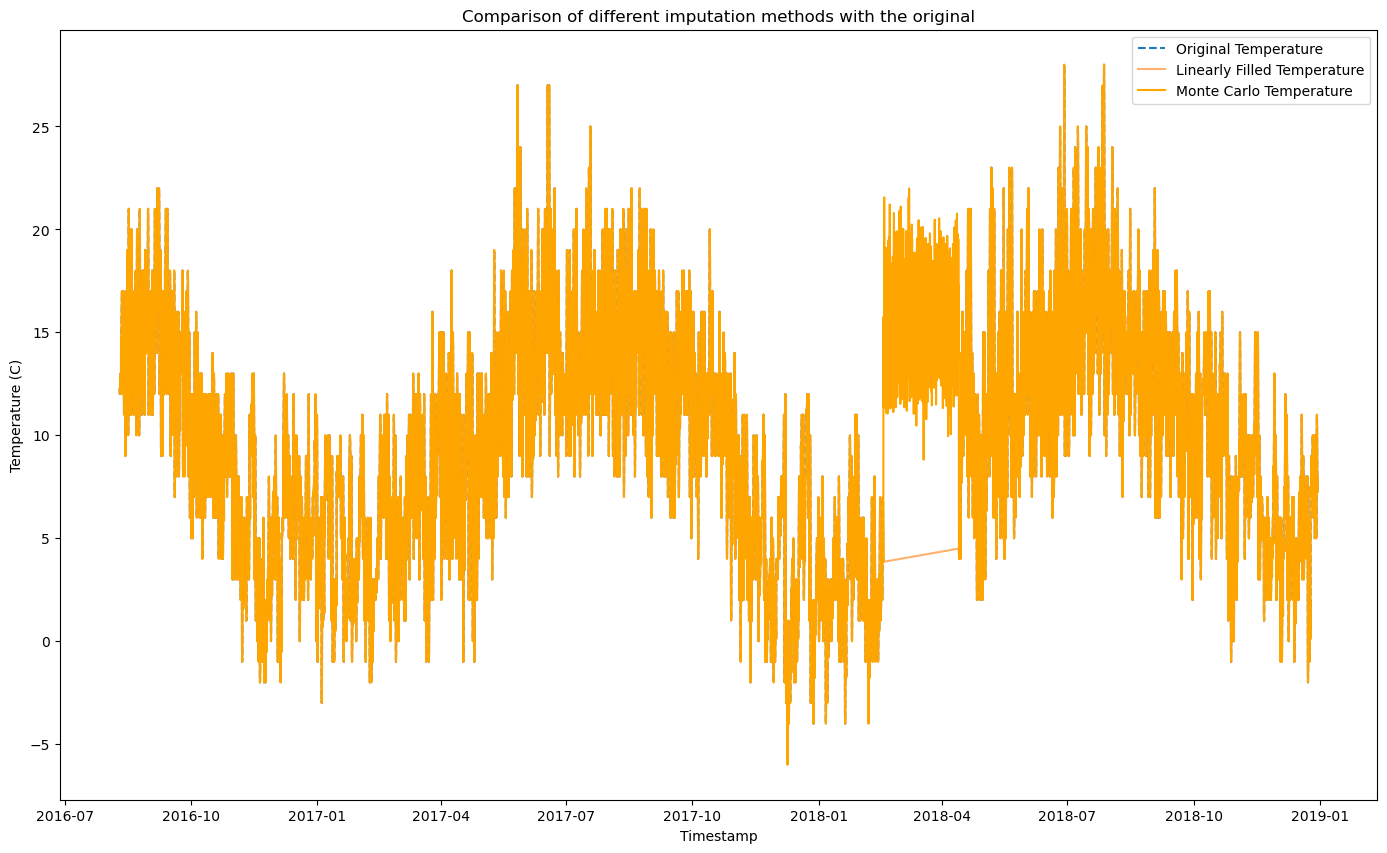

In [37]:
plt.figure(figsize=(17, 10))
plt.plot(hourly_timestamps['temperature'], label = 'Original Temperature', linestyle = '--')
plt.plot(hourly_timestamps['temperature_intepolated'], label = 'Linearly Filled Temperature', alpha = 0.6)
plt.plot(hourly_timestamps['temperature_custom_trend'], label = 'Monte Carlo Temperature', color = 'orange')
plt.legend()
plt.title('Comparison of different imputation methods with the original')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (C)')
plt.show()

In [38]:
temp_2018_missing_period = hourly_timestamps.loc[missing_start:missing_end, 'temperature_monte_carlo']
temp_2017_reference_period = hourly_timestamps.loc[reference_start:reference_end, 'temperature_monte_carlo']

# Calculate the average temperature for each period
average_temp_2018 = temp_2018_missing_period.mean()
average_temp_2017 = temp_2017_reference_period.mean()

print(f"Average temperature for the same period in 2017 (Feb-April): {average_temp_2017:.2f}°C")
print(f"Average temperature for the missing period in 2018 (Feb-April): {average_temp_2018:.2f}°C")


Average temperature for the same period in 2017 (Feb-April): 7.40°C
Average temperature for the missing period in 2018 (Feb-April): 9.33°C


In [39]:
year_2017_start = "2017-01-01"
year_2017_end = "2017-12-31"
year_2018_start = "2018-01-01"
year_2018_end = "2018-12-31"

# Extract temperature data for each year
# Assuming hourly_timestamps has a column named 'temperature' with hourly temperature data
temp_2017 = hourly_timestamps.loc[year_2017_start:year_2017_end, 'temperature_monte_carlo']
temp_2018 = hourly_timestamps.loc[year_2018_start:year_2018_end, 'temperature_monte_carlo']

# Calculate the average temperature for each year
average_temp_2017 = temp_2017.mean()
average_temp_2018 = temp_2018.mean()

print(f"Average temperature for 2017: {average_temp_2017:.2f}°C")
print(f"Average temperature for 2018: {average_temp_2018:.2f}°C")

Average temperature for 2017: 9.47°C
Average temperature for 2018: 9.93°C


In [40]:
# apply linear interpolation to the missing values of mintemp and maxtemp in the initial dataset and then apply the sine function method

INSPECT THE MISSING DATES

In [41]:
print(min_max_temp_edin)

                 maxtemp  mintemp
dateforecastfor                  
2016-08-10            13       12
2016-08-11            17       14
2016-08-12            17       12
2016-08-13            16       11
2016-08-14            17        9
...                  ...      ...
2018-12-26            10        7
2018-12-27            10        6
2018-12-28            10        5
2018-12-29            11        5
2018-12-30            11        7

[818 rows x 2 columns]


In [42]:
print(min_max_temp_edin.index.max() - min_max_temp_edin.index.min())

872 days 00:00:00


In [43]:
daily_temps = pd.date_range(start=min_max_temp_edin.index.min(), end = min_max_temp_edin.index.max(), freq = 'D')

In [44]:
daily_temps = pd.DataFrame(daily_temps)

In [45]:
daily_temps.index = daily_temps[0]

In [46]:
daily_temps.index.name = 'timestamp'

In [47]:
total_daily_temps = pd.merge(left=daily_temps, right=min_max_temp_edin, how= 'left', left_on= daily_temps.index, right_on=min_max_temp_edin.index)

In [48]:
dates_missing_values = []
[dates_missing_values.append(total_daily_temps.iloc[i]) for i in range(len(total_daily_temps)) if total_daily_temps.iloc[i].isnull().any()]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [49]:
dates_missing_values

[key_0      2018-02-17 00:00:00
 0          2018-02-17 00:00:00
 maxtemp                    NaN
 mintemp                    NaN
 Name: 556, dtype: object,
 key_0      2018-02-18 00:00:00
 0          2018-02-18 00:00:00
 maxtemp                    NaN
 mintemp                    NaN
 Name: 557, dtype: object,
 key_0      2018-02-19 00:00:00
 0          2018-02-19 00:00:00
 maxtemp                    NaN
 mintemp                    NaN
 Name: 558, dtype: object,
 key_0      2018-02-20 00:00:00
 0          2018-02-20 00:00:00
 maxtemp                    NaN
 mintemp                    NaN
 Name: 559, dtype: object,
 key_0      2018-02-21 00:00:00
 0          2018-02-21 00:00:00
 maxtemp                    NaN
 mintemp                    NaN
 Name: 560, dtype: object,
 key_0      2018-02-22 00:00:00
 0          2018-02-22 00:00:00
 maxtemp                    NaN
 mintemp                    NaN
 Name: 561, dtype: object,
 key_0      2018-02-23 00:00:00
 0          2018-02-23 00:00:00
 maxte

In [50]:
missing_dates = [entry['key_0'] for entry in dates_missing_values]

In [51]:
print(min(missing_dates))
print(max(missing_dates))

2018-02-17 00:00:00
2018-04-12 00:00:00


In [52]:
total_daily_temps = total_daily_temps.drop(columns= 0)

In [53]:
total_daily_temps.index = total_daily_temps['key_0']

In [54]:
total_daily_temps = total_daily_temps.drop(columns='key_0')

In [55]:
total_daily_temps.index.name = 'timestamp'

In [56]:
total_daily_temps['maxtemp_interpolated'] = total_daily_temps['maxtemp'].interpolate(method='linear')
total_daily_temps['mintemp_interpolated'] = total_daily_temps['mintemp'].interpolate(method='linear')

In [57]:
print(f"Original average of max temp (including missing values): {total_daily_temps['maxtemp'].mean()}")
print(f"Interpolated average max temp: {total_daily_temps['maxtemp_interpolated'].mean()}")
print("")
print(f"Original average of min temp (including missing values): {total_daily_temps['mintemp'].mean()}")
print(f"Interpolated average min temp: {total_daily_temps['mintemp_interpolated'].mean()}")

Original average of max temp (including missing values): 12.819070904645477
Interpolated average max temp: 12.420962199312715

Original average of min temp (including missing values): 6.5513447432762835
Interpolated average min temp: 6.327605956471936


In [58]:
print(total_daily_temps.isnull().sum())

maxtemp                 55
mintemp                 55
maxtemp_interpolated     0
mintemp_interpolated     0
dtype: int64


In [59]:
all_hourly_temps_dict = {}

for key, row in total_daily_temps.iterrows():
    all_hourly_temps_dict[key] = hourly_temps_estimation(row['maxtemp_interpolated'], row['mintemp_interpolated'])

In [60]:
all_hourly_temps_dict

{Timestamp('2016-08-10 00:00:00'): [12.25,
  12.146446609406727,
  12.066987298107781,
  12.017037086855465,
  12.0,
  12.017037086855465,
  12.066987298107781,
  12.146446609406727,
  12.25,
  12.37059047744874,
  12.5,
  12.62940952255126,
  12.75,
  12.853553390593273,
  12.933012701892219,
  12.982962913144535,
  13.0,
  12.982962913144535,
  12.933012701892219,
  12.853553390593273,
  12.75,
  12.62940952255126,
  12.5,
  12.37059047744874],
 Timestamp('2016-08-11 00:00:00'): [14.75,
  14.439339828220179,
  14.200961894323342,
  14.051111260566397,
  14.0,
  14.051111260566397,
  14.200961894323342,
  14.439339828220179,
  14.75,
  15.111771432346218,
  15.5,
  15.888228567653782,
  16.25,
  16.560660171779823,
  16.799038105676658,
  16.948888739433603,
  17.0,
  16.948888739433603,
  16.799038105676658,
  16.560660171779823,
  16.25,
  15.888228567653782,
  15.5,
  15.11177143234622],
 Timestamp('2016-08-12 00:00:00'): [13.25,
  12.732233047033631,
  12.334936490538905,
  12.085

In [61]:
hourly_timestamps

,temperature,temperature_intepolated,temperature_monte_carlo,temperature_custom_trend
hourly_timestamp,,,,
2016-08-10 00:00:00,12.250000,12.250000,12.250000,12.250000
2016-08-10 01:00:00,12.146447,12.146447,12.146447,12.146447
2016-08-10 02:00:00,12.066987,12.066987,12.066987,12.066987
2016-08-10 03:00:00,12.017037,12.017037,12.017037,12.017037
2016-08-10 04:00:00,12.000000,12.000000,12.000000,12.000000
...,...,...,...,...
2018-12-29 20:00:00,9.500000,9.500000,9.500000,9.500000
2018-12-29 21:00:00,8.776457,8.776457,8.776457,8.776457
2018-12-29 22:00:00,8.000000,8.000000,8.000000,8.000000


In [62]:
hourly_timestamps['hourly_timestamp'] = hourly_timestamps.index

In [63]:
hourly_timestamps['temperature_refined'] = hourly_timestamps['hourly_timestamp'].apply(get_temperature, args=(all_hourly_temps_dict,))

In [64]:
print(hourly_timestamps.isnull().sum())

temperature                 1320
temperature_intepolated        0
temperature_monte_carlo        0
temperature_custom_trend       0
hourly_timestamp               0
temperature_refined            0
dtype: int64


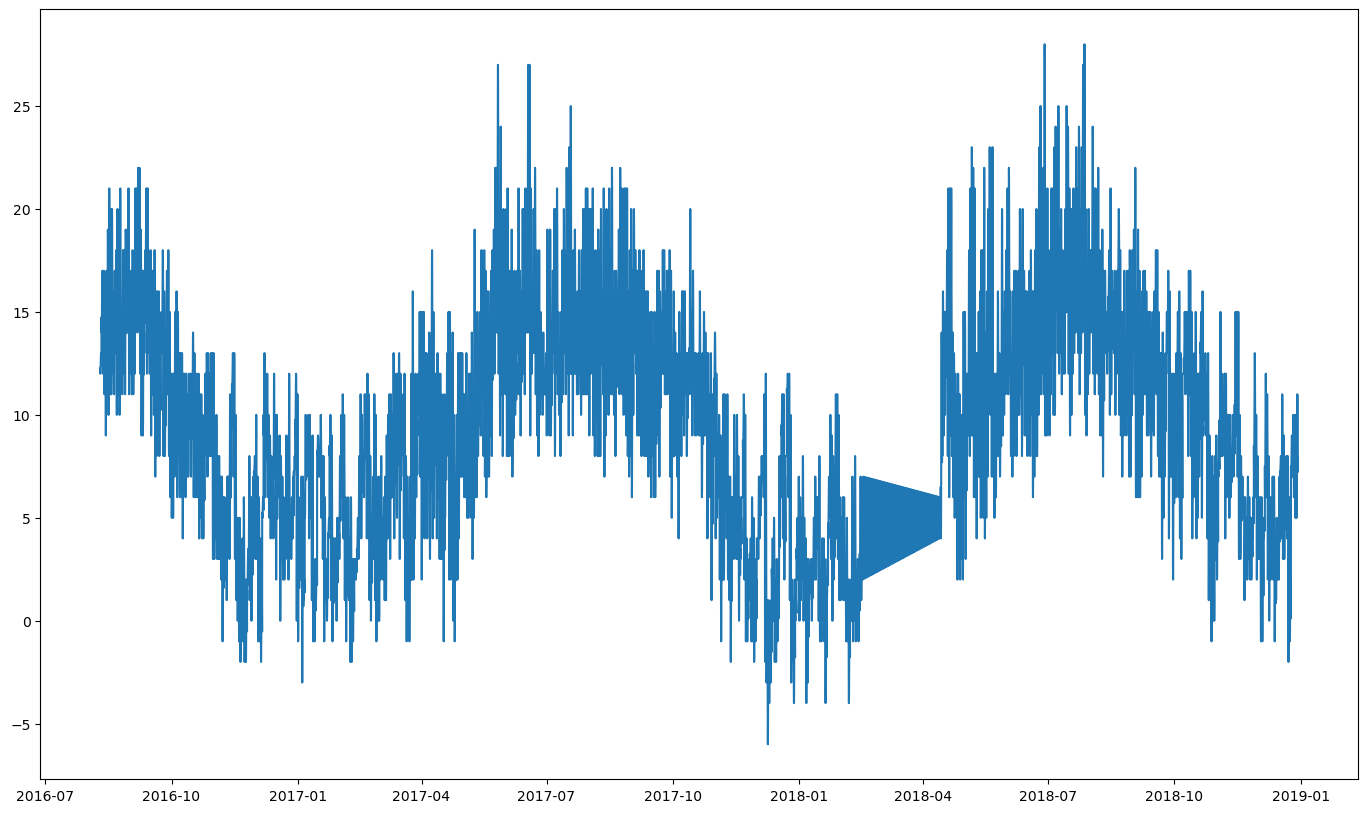

In [65]:
plt.figure(figsize=(17,10))
plt.plot(hourly_timestamps['temperature_refined'], label = 'Temperature_Refined')
plt.show()